In [11]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
import sqlite3
import sys

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import time,warnings

from sklearn.linear_model import LinearRegression

In [12]:
conn = sqlite3.connect('../queries/retail.db')
df = pd.read_sql_query("SELECT * FROM mostvalue_client WHERE CustomerId IS NOT NULL", conn)
conn.close()

df.isnull().sum()
df.head()

,CustomerId,total_items,unique_items,avg_price_unit,Revenue
0,14646.0,2085,703,2.59,279489.02
1,18102.0,433,151,11.92,256438.49
2,17450.0,351,127,9.46,187482.17
3,14911.0,5903,1794,5.26,132572.62
4,12415.0,778,444,3.21,123725.45


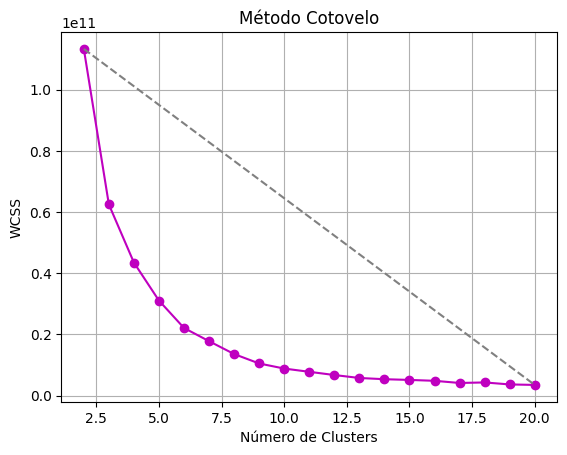

In [13]:

def calculate_wcss(data):
    wcss = []

    for n in range(2, 21):
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)
    
    return wcss

wcss = calculate_wcss(df)
plt.plot(range(2,21), wcss, marker='o', color='m')
plt.plot([2, 20], [wcss[0], wcss[-1]], color='gray', linestyle='--')
plt.grid(True)
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.title('Método Cotovelo')
plt.show()


Estamos procurando o ponto que indica o maior equilíbrio entre maior homogeneidade dentro do cluster e a mior diferenca entre clusters, é o ponto da curva mais distante de uma reta tracaada entre os ponto (2, 20)

E temos a formula que calcula essa maior distância no nosso modelo: 

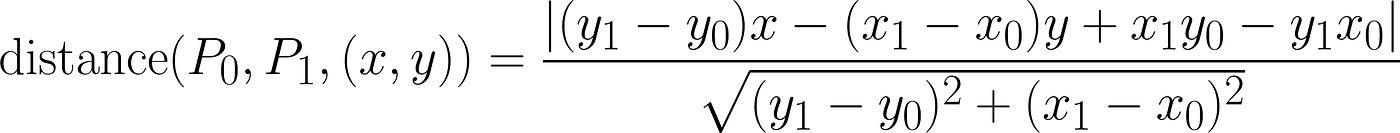

O nosso P0 é nosso: 2
O nosso P1 é nosso: 20

In [14]:
def good_optional_cluster(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[-1]

    distance = []

    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]

        numerator = abs((y2 - y1)*x0 - (x2 - x1)*y0 + x2*y1 - y2*x1)
        denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distance.append(numerator / denominator)
    
    return distance.index(max(distance)) + 2

In [15]:
n = good_optional_cluster(wcss)
print(f'Número ótimo: {n} Clusters')

Número ótimo: 6 Clusters


In [16]:
kmeans = KMeans(n_clusters=n, n_init=10, random_state=42)
kmeans.fit(df)

df['Cluster'] = kmeans.labels_

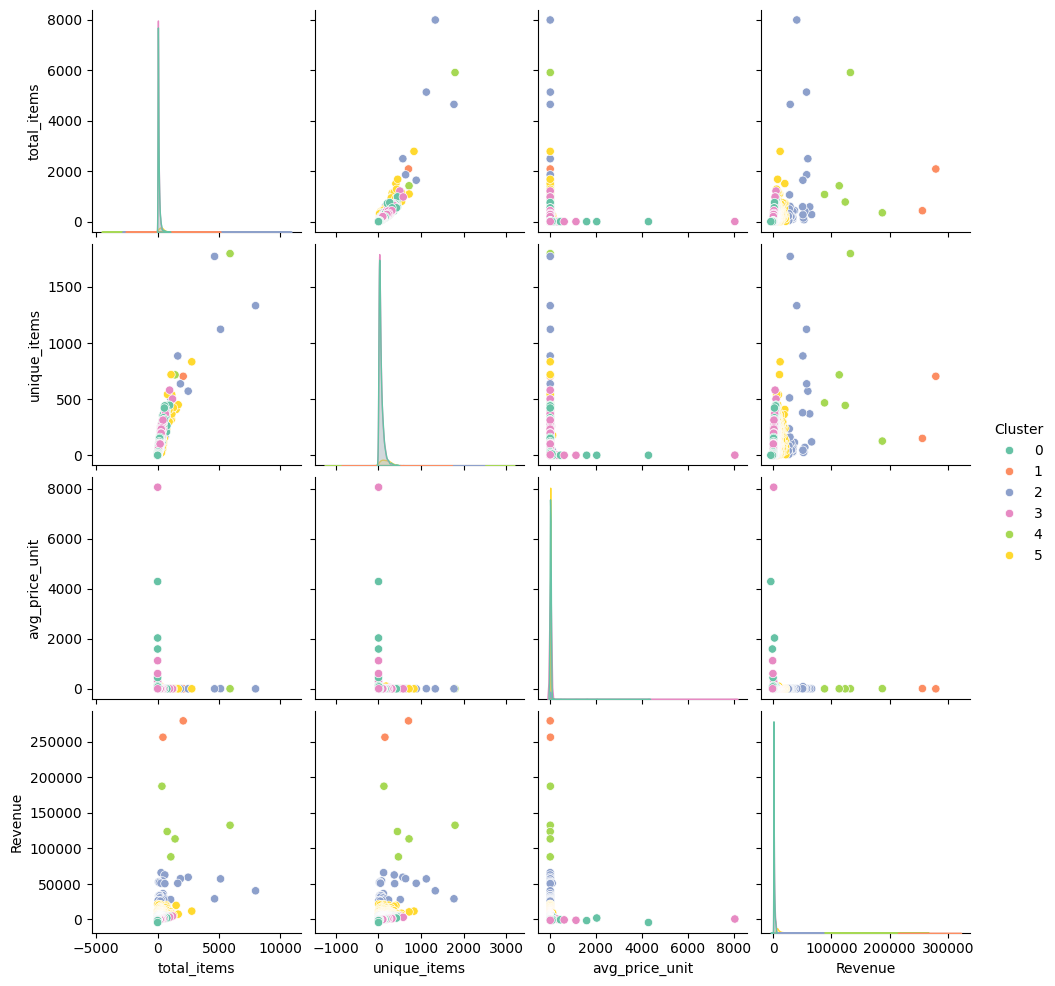

In [17]:
df.groupby('Cluster').describe()
df.groupby('Cluster').mean()
df = df.drop(columns=['CustomerId'])
sns.pairplot(df, hue='Cluster', palette='Set2')


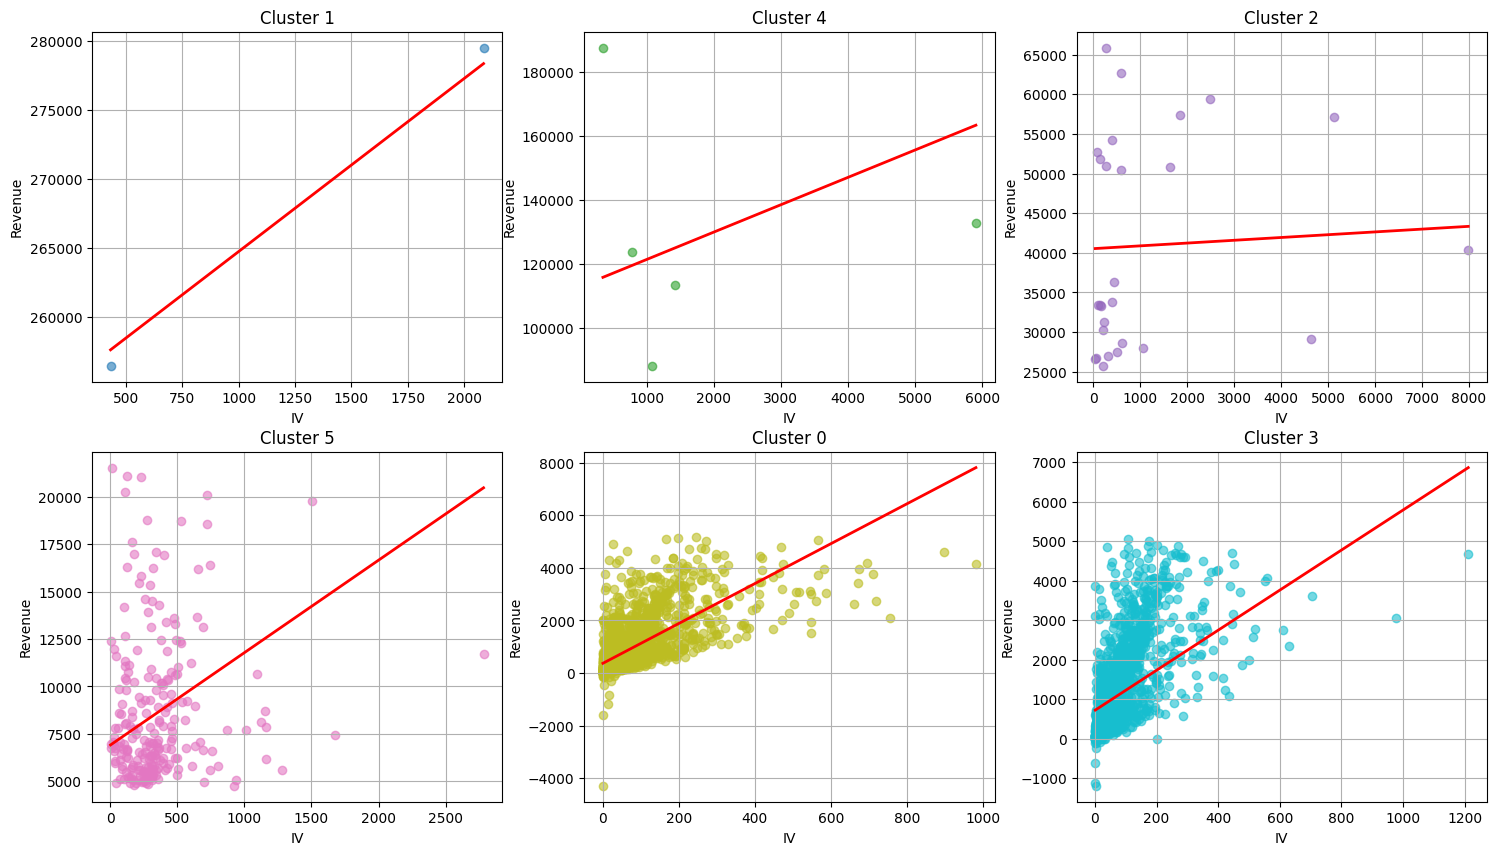

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

resultados = {}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

cores = plt.cm.tab10(np.linspace(0, 1, len(df['Cluster'].unique())))


for i, cluster in enumerate(df['Cluster'].unique()):
    ax = axes[i]

    dados_cluster = df[df['Cluster'] == cluster]
    X = dados_cluster.drop(columns=['Revenue', 'Cluster']).values
    y = dados_cluster['Revenue'].values

    model = LinearRegression()
    model.fit(X, y)
    resultados[cluster] = model

    plt.figure(figsize=(8, 5))
    ax.scatter(X[:, 0], y, color=cores[i], alpha=0.6, label=f'Dados Cluster {cluster}')

    X_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100).reshape(-1, 1)
    mean_features = X[:, 1:].mean(axis=0)
    X_plot = np.hstack([X_range, np.tile(mean_features, (100, 1))])

    y_pred = model.predict(X_plot)
    ax.plot(X_range, y_pred, color='red', linewidth=2, label='Regressão')

    ax.set_title(f'Cluster {cluster}')
    ax.set_xlabel('IV')
    ax.set_ylabel('Revenue')
    ax.grid(True)

plt.tight_layout()
plt.show()
